In [1]:
# import required Libraries
from textblob import TextBlob
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import re
import string
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from bs4 import BeautifulSoup
from html import unescape
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset
tweets=pd.read_csv("Russia_invade.csv")
tweets=tweets.append(pd.read_csv("Russian_border_Ukraine.csv"))
tweets=tweets.append(pd.read_csv("Russian_troops.csv"))
tweets=tweets.append(pd.read_csv("StandWithUkraine.csv"))
tweets=tweets.append(pd.read_csv("Ukraine_border.csv"))
tweets=tweets.append(pd.read_csv("Ukraine_nato.csv"))
tweets=tweets.append(pd.read_csv("Ukraine_troops.csv"))
tweets=tweets.append(pd.read_csv("Ukraine_war.csv"))

In [3]:
# Data Preprocessing

# remove Duplicates
tweets.drop_duplicates(inplace=True) 
# get only english language tweets
tweets = tweets[tweets['lang'] == 'en']
# Remove punctuations, tags, annotations, and convert all text to lower
def clean_tweet(message):
    message = message.lower()
    #remove urls
    message = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', message)
    #unescape characters
    soup = BeautifulSoup(unescape(message), 'lxml')
    message = soup.text
    #remove emoticons
    regrex_pattern = re.compile(pattern = "["   
        #graphs, symbols                        
        u"\U0001F300-\U0001F5FF" 
        #emoticons
        u"\U0001F600-\U0001F64F"
        #flags
        u"\U0001F1E0-\U0001F1FF" 
        #map and transport
        u"\U0001F680-\U0001F6FF"  
                           "]+", flags = re.UNICODE)
    message = regrex_pattern.sub(r'', message)
    #remove redundant white spaces
    message = re.sub(' +', ' ', message)
    #remove special characters 
    message = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', message)
    return message
tweets['content'] = tweets['content'].apply(clean_tweet)

Total Positive Tweets % : 41.70
Total Negative Tweets % : 26.92
Total Neutral Tweets % : 31.37


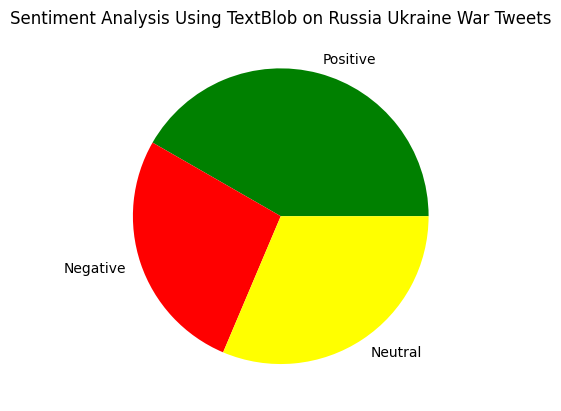

In [4]:
# Sentiment Analysis Using TextBlob 
textBlobtweet = tweets[['content']]
def getSubjectivity(review):
    return TextBlob(review).sentiment.subjectivity

def getPolarity(review):
    return TextBlob(review).sentiment.polarity

def analysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'
    
textBlobtweet['Subjectivity'] = textBlobtweet['content'].apply(getSubjectivity) 
textBlobtweet['Polarity'] = textBlobtweet['content'].apply(getPolarity) 
textBlobtweet['Analysis'] = textBlobtweet['Polarity'].apply(analysis)
total_pos = len(textBlobtweet.loc[textBlobtweet['Analysis'] == "Positive"])
total_neg = len(textBlobtweet.loc[textBlobtweet['Analysis'] == "Negative"])
total_neu = len(textBlobtweet.loc[textBlobtweet['Analysis'] == "Neutral"])
total_tweets = len(textBlobtweet)
print("Total Positive Tweets % : {:.2f}".format((total_pos/total_tweets)*100))
print("Total Negative Tweets % : {:.2f}".format((total_neg/total_tweets)*100))
print("Total Neutral Tweets % : {:.2f}".format((total_neu/total_tweets)*100))
labels = ["Positive", "Negative", "Neutral"]
colors = ["Green", "Red", "Yellow"]
plt.figure() 
plt.pie([total_pos, total_neg, total_neu], colors=colors, labels=labels)
plt.title("Sentiment Analysis Using TextBlob on Russia Ukraine War Tweets")
plt.show()

Total Positive Tweets % : 13.24
Total Negative Tweets % : 34.10
Total Neutral Tweets % : 52.66


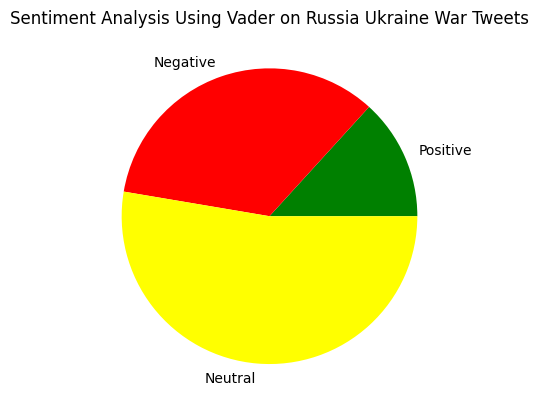

In [5]:
# Sentiment Analysis Using Vader
vaderdata = tweets[['content']]
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(review):
    vs = analyzer.polarity_scores(review)
    return vs['compound']
vaderdata['Vader Sentiment'] = vaderdata['content'].apply(vadersentimentanalysis)
# function to analyse
def vader_analysis(compound):
    if compound >= 0.5:
        return 'Positive'
    elif compound <= -0.5 :
        return 'Negative'
    else:
        return 'Neutral'
vaderdata['Vader Analysis'] = vaderdata['Vader Sentiment'].apply(vader_analysis)
total_pos = len(vaderdata.loc[vaderdata['Vader Analysis'] == "Positive"])
total_neg = len(vaderdata.loc[vaderdata['Vader Analysis'] == "Negative"])
total_neu = len(vaderdata.loc[vaderdata['Vader Analysis'] == "Neutral"])
total_tweets = len(vaderdata)
print("Total Positive Tweets % : {:.2f}".format((total_pos/total_tweets)*100))
print("Total Negative Tweets % : {:.2f}".format((total_neg/total_tweets)*100))
print("Total Neutral Tweets % : {:.2f}".format((total_neu/total_tweets)*100))
labels = ["Positive", "Negative", "Neutral"]
colors = ["Green", "Red", "Yellow"]
plt.figure() 
plt.pie([total_pos, total_neg, total_neu], colors=colors, labels=labels)
plt.title("Sentiment Analysis Using Vader on Russia Ukraine War Tweets")
plt.show()

In [17]:
# Generating N Grams
import nltk
from nltk.corpus import stopwords
from collections import defaultdict
nltk.download('stopwords')

positiveValues=defaultdict(int)
negativeValues=defaultdict(int)
neutralValues=defaultdict(int)

def generate_N_grams(text,ngram=1):
    words=[word for word in text.split(" ") if word not in set(stopwords.words('english'))]  
    temp=zip(*[words[i:] for i in range(0,ngram)])
    ans=[' '.join(ngram) for ngram in temp]
    return ans

# Unigram Analysis
#get the count of every word where sentiment="positive"
for text in textBlobtweet[textBlobtweet.Analysis=="Positive"].content:
    for word in generate_N_grams(text):
        positiveValues[word]+=1

#get the count of every word where sentiment="negative"
for text in textBlobtweet[textBlobtweet.Analysis=="Negative"].content:
    for word in generate_N_grams(text):
        negativeValues[word]+=1

#get the count of every word sentiment="neutral"
for text in textBlobtweet[textBlobtweet.Analysis=="Neutral"].content:
    for word in generate_N_grams(text):
        neutralValues[word]+=1

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\santo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


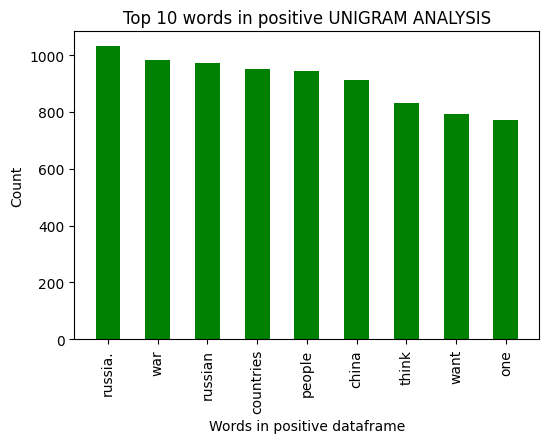

In [79]:
#Plotting the top unigrams of different sentiments (Positive, Negative, Neutral)

df_positive=pd.DataFrame(sorted(positiveValues.items(),key=lambda x:x[1],reverse=True))
df_negative=pd.DataFrame(sorted(negativeValues.items(),key=lambda x:x[1],reverse=True))
df_neutral=pd.DataFrame(sorted(neutralValues.items(),key=lambda x:x[1],reverse=True))

df_positive = df_positive.dropna()
df_positive[0].replace('', np.nan, inplace=True)
df_positive = df_positive.dropna()

posd1=df_positive[0][11:20]
posd2=df_positive[1][11:20]

negd1=df_negative[0][11:20]
negd2=df_negative[1][11:20]

neud1=df_neutral[0][11:20]
neud2=df_neutral[1][11:20]

plt.figure(figsize=(6,4))
plt.bar(posd1,posd2, color ='green',width = 0.5)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Top 10 words in positive UNIGRAM ANALYSIS")
plt.show()

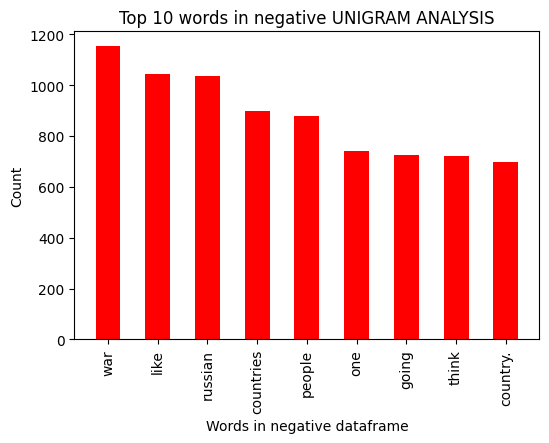

In [80]:
plt.figure(figsize=(6,4))
plt.bar(negd1,negd2, color ='red',width = 0.5)
plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Top 10 words in negative UNIGRAM ANALYSIS")
plt.show()

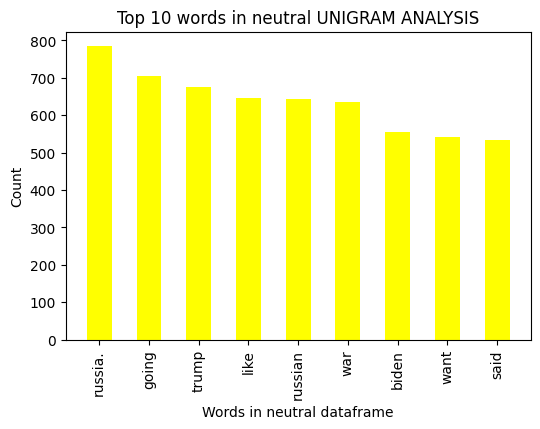

In [81]:
plt.figure(figsize=(6,4))
plt.bar(neud1,neud2, color ='yellow',width = 0.5)
plt.xlabel("Words in neutral dataframe")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Top 10 words in neutral UNIGRAM ANALYSIS")
plt.show()

In [75]:
# Bigrams Analysis
positiveValues2=defaultdict(int)
negativeValues2=defaultdict(int)
neutralValues2=defaultdict(int)

for text in textBlobtweet[textBlobtweet.Analysis=="Positive"].content:
    for word in generate_N_grams(text,2):
        positiveValues2[word]+=1
        
for text in textBlobtweet[textBlobtweet.Analysis=="Negative"].content:
    for word in generate_N_grams(text,2):
        negativeValues2[word]+=1
        
for text in textBlobtweet[textBlobtweet.Analysis=="Neutral"].content:
    for word in generate_N_grams(text,2):
        neutralValues2[word]+=1

<function matplotlib.pyplot.show(close=None, block=None)>

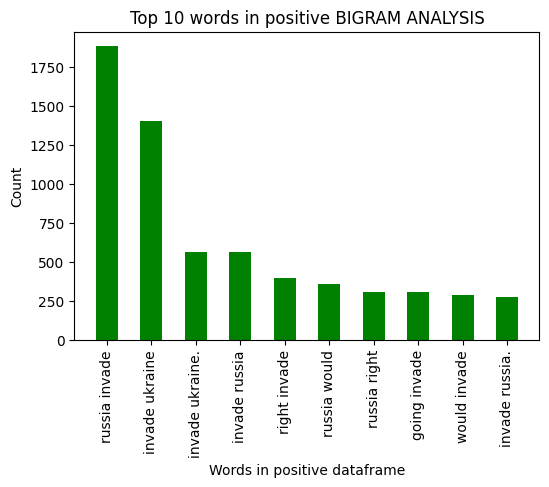

In [82]:
#Plotting the top bigrams of different sentiments (Positive, Negative, Neutral)

df_positive2=pd.DataFrame(sorted(positiveValues2.items(),key=lambda x:x[1],reverse=True))
df_negative2=pd.DataFrame(sorted(negativeValues2.items(),key=lambda x:x[1],reverse=True))
df_neutral2=pd.DataFrame(sorted(neutralValues2.items(),key=lambda x:x[1],reverse=True))

posd1bi=df_positive2[0][:10]
posd2bi=df_positive2[1][:10]

negd1bi=df_negative2[0][:10]
negd2bi=df_negative2[1][:10]

neud1bi=df_neutral2[0][:10]
neud2bi=df_neutral2[1][:10]

plt.figure(1,figsize=(6,4))
plt.bar(posd1bi,posd2bi, color ='green',width = 0.5)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Top 10 words in positive BIGRAM ANALYSIS")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

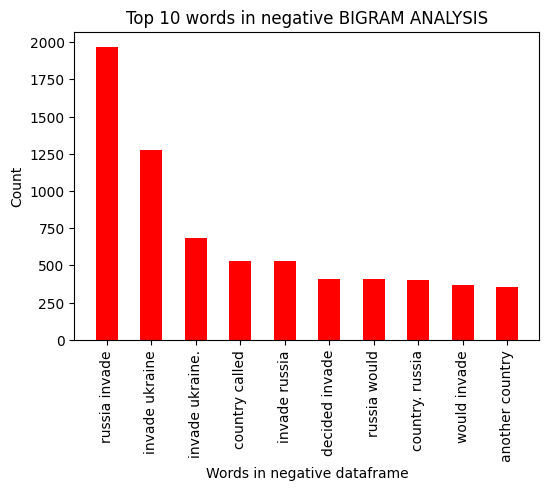

In [83]:
plt.figure(1,figsize=(6,4))
plt.bar(negd1bi,negd2bi, color ='red',width = 0.5)
plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Top 10 words in negative BIGRAM ANALYSIS")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

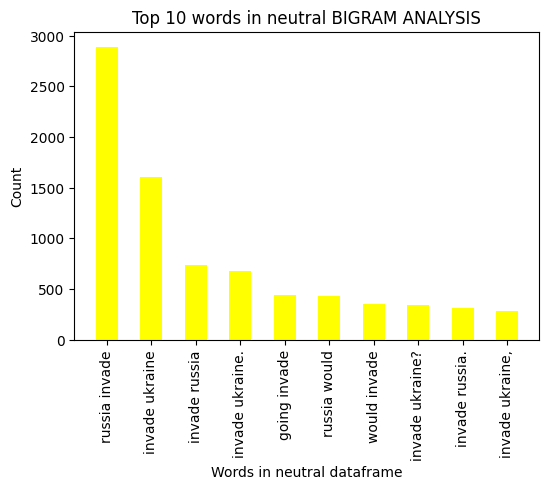

In [84]:
plt.figure(1,figsize=(6,4))
plt.bar(neud1bi,neud2bi, color ='yellow',width = 0.5)
plt.xlabel("Words in neutral dataframe")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Top 10 words in neutral BIGRAM ANALYSIS")
plt.show

In [85]:
# Trigrams Analysis

positiveValues3=defaultdict(int)
negativeValues3=defaultdict(int)
neutralValues3=defaultdict(int)

for text in textBlobtweet[textBlobtweet.Analysis=="Positive"].content:
    for word in generate_N_grams(text,3):
        positiveValues3[word]+=1
        
for text in textBlobtweet[textBlobtweet.Analysis=="Negative"].content:
    for word in generate_N_grams(text,3):
        negativeValues3[word]+=1

for text in textBlobtweet[textBlobtweet.Analysis=="Neutral"].content:
    for word in generate_N_grams(text,3):
        neutralValues3[word]+=1

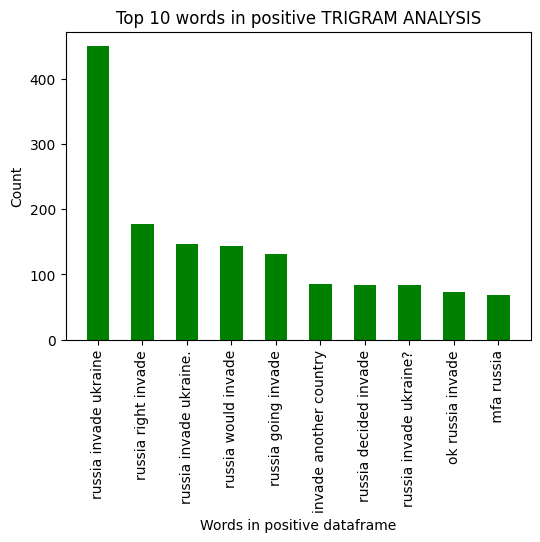

In [95]:
#Plotting the top trigram of different sentiments (Positive, Negative, Neutral)

df_positive3=pd.DataFrame(sorted(positiveValues3.items(),key=lambda x:x[1],reverse=True))
df_negative3=pd.DataFrame(sorted(negativeValues3.items(),key=lambda x:x[1],reverse=True))
df_neutral3=pd.DataFrame(sorted(neutralValues3.items(),key=lambda x:x[1],reverse=True))

posd1tri=df_positive3[0][:10]
posd2tri=df_positive3[1][:10]

negd1tri=df_negative3[0][:10]
negd2tri=df_negative3[1][:10]

neud1tri=df_neutral3[0][:10]
neud2tri=df_neutral3[1][:10]

plt.figure(1,figsize=(6,4))
plt.bar(posd1tri, posd2tri, color ='green', width = 0.5)
plt.xlabel("Words in positive dataframe")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Top 10 words in positive TRIGRAM ANALYSIS")
plt.show()

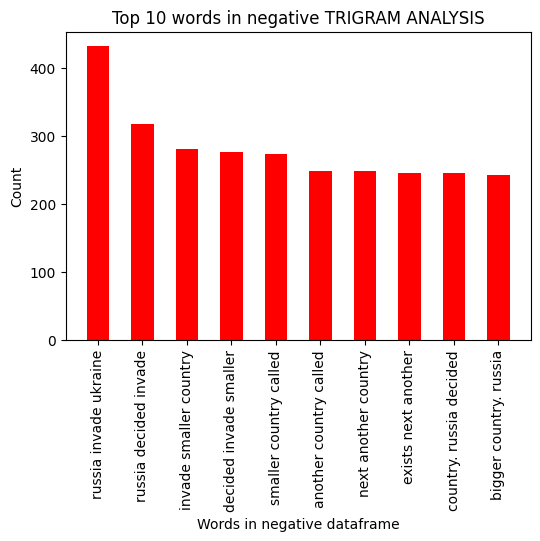

In [93]:
plt.figure(1,figsize=(6,4))
plt.bar(negd1tri, negd2tri, color ='red', width = 0.5)
plt.xlabel("Words in negative dataframe")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Top 10 words in negative TRIGRAM ANALYSIS")
plt.show()

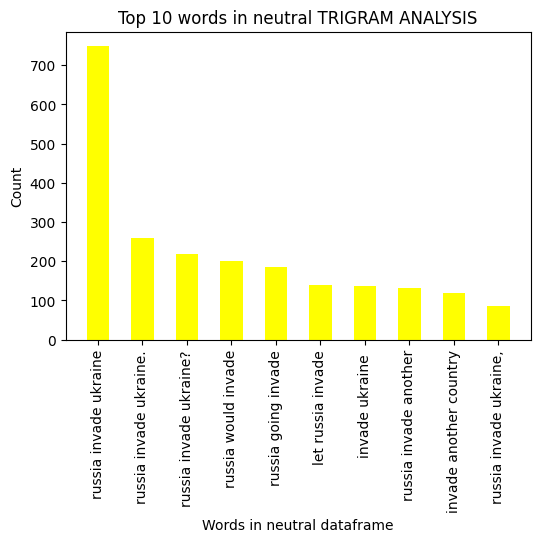

In [94]:
plt.figure(1,figsize=(6,4))
plt.bar(neud1tri, neud2tri, color ='yellow', width = 0.5)
plt.xlabel("Words in neutral dataframe")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.title("Top 10 words in neutral TRIGRAM ANALYSIS")
plt.show()